Loading: C:\Users\ASUS\Downloads\archive (1)\Sleep_health_and_lifestyle_dataset.csv
Shape: (374, 13)
['Person ID', 'Gender', 'Age', 'Occupation', 'Sleep Duration', 'Quality of Sleep', 'Physical Activity Level', 'Stress Level', 'BMI Category', 'Blood Pressure', 'Heart Rate', 'Daily Steps', 'Sleep Disorder']

--- Head ---
   Person ID Gender  Age            Occupation  Sleep Duration  \
0          1   Male   27     Software Engineer             6.1   
1          2   Male   28                Doctor             6.2   
2          3   Male   28                Doctor             6.2   
3          4   Male   28  Sales Representative             5.9   
4          5   Male   28  Sales Representative             5.9   

   Quality of Sleep  Physical Activity Level  Stress Level BMI Category  \
0                 6                       42             6   Overweight   
1                 6                       60             8       Normal   
2                 6                       60            

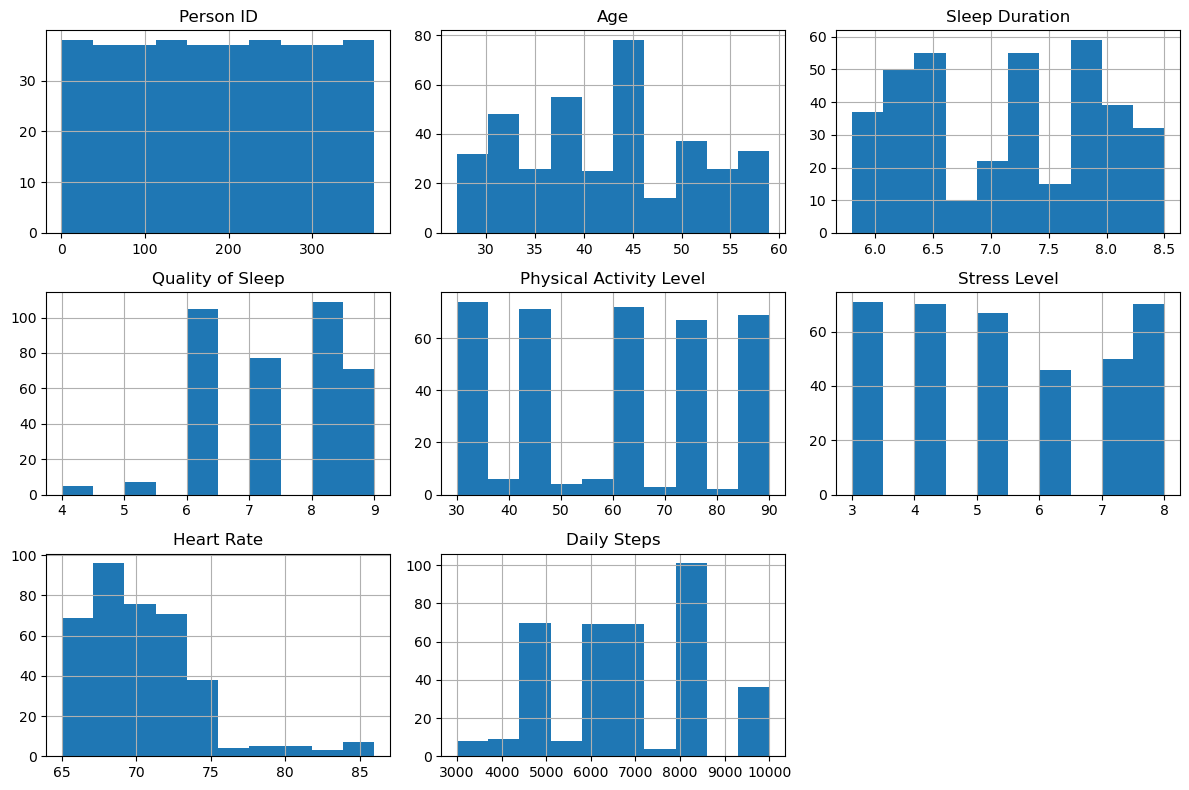


Selected target column for modeling: Sleep Duration
Inferred task: regression
Numeric cols: ['Person ID', 'Age', 'Quality of Sleep', 'Physical Activity Level', 'Stress Level', 'Heart Rate', 'Daily Steps']
Categorical cols: ['Gender', 'Occupation', 'BMI Category', 'Blood Pressure', 'Sleep Disorder']

Training RandomForestRegressor
  CV R2 (5-fold): 0.9866 (std 0.0051)
  Test R2: 0.9924617335699175
  Test MAE: 0.042180000000001945

Training GradientBoostingRegressor
  CV R2 (5-fold): 0.9865 (std 0.0038)
  Test R2: 0.9901344620620343
  Test MAE: 0.05499529213654133

Training LinearRegression
  CV R2 (5-fold): 0.8815 (std 0.0346)
  Test R2: 0.9633668780605239
  Test MAE: 0.09486416224736939

Best model: RandomForestRegressor
Saved best model to C:\Users\ASUS\Downloads\archive (1)\best_model.pkl
Saved model_report.csv to /mnt/data/model_report.csv

Example of loading the saved model:
import joblib
model = joblib.load('/mnt/data/best_model.pkl')
# then model.predict(X_new)

Notebook finishe

In [5]:
# %%
# 1) Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.metrics import r2_score, mean_absolute_error, accuracy_score, classification_report
import joblib

# %%
# 2) Config
CSV_PATH = r"C:\Users\ASUS\Downloads\archive (1)\Sleep_health_and_lifestyle_dataset.csv"
OUT_MODEL_PATH = r"C:\Users\ASUS\Downloads\archive (1)\best_model.pkl"
RANDOM_STATE = 42

# %%
# 3) Load data
print("Loading:", CSV_PATH)
df = pd.read_csv(CSV_PATH)
print("Shape:", df.shape)
print(df.columns.tolist())

# Quick preview
print('\n--- Head ---')
print(df.head())
print('\n--- Dtypes ---')
print(df.dtypes)

# %%
# 4) Quick EDA
print('\nMissing values per column:')
print(df.isnull().sum())
print('\nBasic description (numeric):')
print(df.describe().T)

# Optional: show simple plots
try:
    numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
    if len(numeric_cols) > 0:
        df[numeric_cols].hist(figsize=(12, 8))
        plt.tight_layout()
        plt.show()
except Exception as e:
    print('Plotting failed:', e)

# %%
# 5) Auto-select target column
# Preference: any column containing 'sleep' (case-insensitive), otherwise last column
sleep_cols = [c for c in df.columns if 'sleep' in c.lower()]
if len(sleep_cols) > 0:
    target_col = sleep_cols[0]
else:
    target_col = df.columns[-1]

print('\nSelected target column for modeling:', target_col)

# %%
# 6) Determine task type
n_unique = df[target_col].nunique(dropna=True)
is_classification = False
if df[target_col].dtype == 'object' or n_unique <= 10:
    is_classification = True

print('Inferred task:', 'classification' if is_classification else 'regression')

# %%
# 7) Prepare features and labels
X = df.drop(columns=[target_col]).copy()
y = df[target_col].copy()

# Drop columns that are constant
const_cols = [c for c in X.columns if X[c].nunique(dropna=True) <= 1]
if const_cols:
    print('Dropping constant columns:', const_cols)
    X.drop(columns=const_cols, inplace=True)

num_cols = X.select_dtypes(include=['number']).columns.tolist()
cat_cols = X.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
print(f'Numeric cols: {num_cols}\nCategorical cols: {cat_cols}')

# %%
# 8) Build preprocessing pipelines
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='__MISSING__')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols)
], remainder='drop')

# %%
# 9) Define candidate models
if is_classification:
    candidates = {
        'RandomForest': RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE),
        'GradientBoosting': GradientBoostingClassifier(n_estimators=200, random_state=RANDOM_STATE),
        'LogisticRegression': LogisticRegression(max_iter=1000)
    }
else:
    candidates = {
        'RandomForestRegressor': RandomForestRegressor(n_estimators=200, random_state=RANDOM_STATE),
        'GradientBoostingRegressor': GradientBoostingRegressor(n_estimators=200, random_state=RANDOM_STATE),
        'LinearRegression': LinearRegression()
    }

# %%
# 10) Train / CV / Evaluate
# If classification and >1 unique values, stratify
stratify = y if (is_classification and n_unique>1) else None
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=RANDOM_STATE, stratify=stratify)

results = {}
for name, model in candidates.items():
    print('\nTraining', name)
    pipe = Pipeline([('preprocessor', preprocessor), ('model', model)])
    # cross-val
    try:
        if is_classification:
            scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring='accuracy')
            cv_mean = np.mean(scores)
            print(f'  CV accuracy (5-fold): {cv_mean:.4f} (std {np.std(scores):.4f})')
        else:
            scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring='r2')
            cv_mean = np.mean(scores)
            print(f'  CV R2 (5-fold): {cv_mean:.4f} (std {np.std(scores):.4f})')
    except Exception as e:
        print('  Cross-val failed:', e)
        cv_mean = None
    # fit and test
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    if is_classification:
        acc = accuracy_score(y_test, y_pred)
        print('  Test accuracy:', acc)
        print('  Classification report:\n', classification_report(y_test, y_pred))
        results[name] = {'cv_score': cv_mean, 'test_score': acc, 'pipeline': pipe}
    else:
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        print('  Test R2:', r2)
        print('  Test MAE:', mae)
        results[name] = {'cv_score': cv_mean, 'test_score': r2, 'pipeline': pipe}

# %%
# 11) Choose best model and save it
best_name = max(results.keys(), key=lambda k: (results[k]['test_score'] if results[k]['test_score'] is not None else -1e9))
best = results[best_name]['pipeline']
print('\nBest model:', best_name)
joblib.dump(best, OUT_MODEL_PATH)
print('Saved best model to', OUT_MODEL_PATH)

# %%
# 12) Save a simple CSV report
report = []
for k, v in results.items():
    report.append({'model': k, 'cv_score': v['cv_score'], 'test_score': v['test_score']})
report_df = pd.DataFrame(report).sort_values('test_score', ascending=False)
report_df.to_csv(r'C:\Users\ASUS\Downloads\archive (1)/model_report.csv', index=False)
print('Saved model_report.csv to /mnt/data/model_report.csv')

# %%
# 13) How to load the saved model (example)
print('\nExample of loading the saved model:')
print("import joblib\nmodel = joblib.load('/mnt/data/best_model.pkl')\n# then model.predict(X_new)")

# %%
# END
print('\nNotebook finished. Modify the target_col and candidate models if you want to experiment further.')
